In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [193]:
def cap_table_function(investors, series, shares, options_holders, options_class, options):
    
    #cap table init
    shares_data = []
    options_data = []
    
    for i in range (len(investors)):
        add = shares[i] + len(options_class)*[0]
        shares_data.append(add)
    
    for i in range (len(options_holders)):
        add = len(series)*[0] + options[i]
        options_data.append(add)
        
    data = shares_data + options_data
    index_list = investors + options_holders
    columns_list = series + options_class
    
    cap_table = pd.DataFrame(data, index = index_list, columns = columns_list)
    
    #Add columns total NFD and FD
    cap_table.insert(len(series), "Total NFD", cap_table[series].sum(axis=1))
    cap_table.insert(len(columns_list)+1, "Total FD", cap_table[columns_list].sum(axis=1))
    columns_list.append("Total NFD")
    columns_list.append("Total FD")
    
    #Columns total
    for i in range (len(columns_list)):
        cap_table.loc["Total", columns_list[i]] = cap_table[columns_list[i]].sum()
        
    #% column
    cap_table.insert(len(series)+1, "Total NFD (%)", cap_table["Total NFD"] / cap_table.at["Total", "Total NFD"])
    cap_table.insert(len(columns_list)+1, "Total FD (%)", cap_table["Total FD"] / cap_table.at["Total", "Total FD"])
        
    #format
    format_dict = { i : '{:,.0f}'.format for i in list(cap_table.columns) }
    format_dict["Total NFD (%)"] = '{:,.2%}'.format
    format_dict["Total FD (%)"] = '{:,.2%}'.format

    return (cap_table, cap_table.style.format(format_dict))


def liquid_pref_function(cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, sale_price, options_prices, options, iteration):
    
    init_sale_price = sale_price

    first_step_item = first_step + (first_step == "Carve-out")*(": " + str(carve_out_rate) + "%")
        
    liquid_pref_steps = [first_step_item]
    for i in range (len(series)-1):
        add = series[-1-i].split(' ')[0]
        liquid_pref_steps.append(f"Pref: {add}")
    liquid_pref_steps.append("Prorata")
    liquid_pref_steps
    
    index_list = investors + options_holders

    #liquid pref init
    liquid_pref = pd.DataFrame(index = index_list+["Total"], columns = liquid_pref_steps)
    solde = []
    price_step_list = []

    #Add cash from options
    options_cash = 0
    for i in range (len(options_prices)):
        for j in range (len(options)):
            options_cash = options_cash + options_prices[i] * options[j][i]
    sale_price = sale_price + options_cash

    #First step
    if (first_step == "Nominal"):
        price_step = shares_prices[0]
        price_step_list.append(price_step)
        liquid_pref[liquid_pref_steps[0]] = cap_table["Total FD"] * price_step
    elif (first_step == "Carve-out"):
        price_step = carve_out_rate/100 * sale_price / cap_table.at["Total", "Total FD"]
        price_step_list.append(price_step)
        liquid_pref[liquid_pref_steps[0]] = cap_table["Total FD"] * price_step
    solde.append(sale_price - liquid_pref.at["Total", liquid_pref_steps[0]])


    #Pref
    for i in range (len(liquid_pref_steps)-2):
        price_step = max(0, multiples_pref[i]*shares_prices[-1-i]-price_step_list[0])
        price_step_list.append(price_step)
        if (solde[-1] >= (cap_table.at["Total", series[-1-i]] * price_step)):
            liquid_pref[liquid_pref_steps[i+1]] = cap_table[series[-1-i]] * price_step
        else:
            liquid_pref[liquid_pref_steps[i+1]] = cap_table[series[-1-i]] * solde[-1] / cap_table.at["Total", series[-1-i]]
        solde.append(solde[-1] - liquid_pref.at["Total", liquid_pref_steps[i+1]])

    #prorata
    if (participating):
        price_step = solde[-1] / cap_table.at["Total", "Total FD"]
        price_step_list.append(price_step)
        liquid_pref[liquid_pref_steps[-1]] = cap_table["Total FD (%)"] * solde[-1]
        solde.append(solde[-1] - liquid_pref.at["Total", liquid_pref_steps[-1]])
    else:
        initial_liquid_pref_steps_len = len(liquid_pref_steps)
        initial_price_step_list = price_step_list.copy()
        #catchup
        for i in range (initial_liquid_pref_steps_len-2):
            price_step = initial_price_step_list[-1-i] - (i != 0)*initial_price_step_list[-i]
            price_step_list.append(price_step)
            new_column_value = (cap_table.iloc[:, 0:i+1].sum(axis=1)+cap_table.iloc[:, (len(series)+2):(len(series)+2+len(options_class))].sum(axis=1))
            total = (new_column_value*price_step)["Total"] 
            if (solde[-1] >= total):
                liquid_pref.insert(initial_liquid_pref_steps_len-1+i, f"Catchup {i+1}", new_column_value*price_step)
            else:
                liquid_pref.insert(initial_liquid_pref_steps_len-1+i, f"Catchup {i+1}", new_column_value * solde[-1] / new_column_value["Total"])
            liquid_pref_steps.insert(initial_liquid_pref_steps_len-1+i, f"Catchup {i+1}")
            solde.append(solde[-1] - liquid_pref.at["Total", f"Catchup {i+1}"])
        #prorata
        price_step = solde[-1] / cap_table.at["Total", "Total FD"]
        price_step_list.append(price_step)
        liquid_pref[liquid_pref_steps[-1]] = cap_table["Total FD (%)"] * solde[-1]
        solde.append(solde[-1] - liquid_pref.at["Total", liquid_pref_steps[-1]])

    #Lines total
    for i in range (len(index_list)):
        liquid_pref.loc[index_list[i], "Total proceeds"] = liquid_pref.loc[index_list[i],].sum()

    #Grand total
    liquid_pref.loc["Total","Total proceeds"] = liquid_pref.loc["Total",].sum()
        
    #solde + price_step
    for i in range (len(liquid_pref_steps)):
        liquid_pref.loc["Solde", liquid_pref_steps[i]] = solde[i]
        liquid_pref.loc["Prix", liquid_pref_steps[i]] = price_step_list[i] 

    # vs prorata / delta
    for i in range (len(index_list)):
        liquid_pref.loc[index_list[i], "vs prorata"] = cap_table.at[index_list[i], "Total FD (%)"] * sale_price
        liquid_pref.loc[index_list[i], "% delta"] = liquid_pref.at[index_list[i], "Total proceeds"] / liquid_pref.at[index_list[i], "vs prorata"] - 1
    liquid_pref.loc["Total", "vs prorata"] = cap_table.at["Total", "Total FD (%)"] * sale_price
    liquid_pref.loc["Total", "% delta"] = liquid_pref.at["Total", "Total proceeds"] / liquid_pref.at["Total", "vs prorata"] - 1

    #format
    format_dict = { i : '{:,.2f} €'.format for i in list(liquid_pref.columns)}
    format_dict["% delta"] = '{:,.2%}'.format
    liquid_pref.style.format(format_dict)

    #Check if options exercised
    ordinary_pps = liquid_pref.loc[investors[0],"Total proceeds"] / cap_table.loc[investors[0],"Total FD"]
    if (iteration < len(options_prices)):
        if ((ordinary_pps < options_prices[-1-iteration])):
            new_options = [[0 if index==(len(options_prices)-1-iteration) else j for index, j in enumerate(k)] for k in options]
            new_cap_table, new_cap_styled = cap_table_function(investors, series, shares, options_holders, options_class, new_options)
            return (liquid_pref_function(new_cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, init_sale_price, options_prices, new_options, iteration+1))
        else:
            return(liquid_pref, liquid_pref.style.format(format_dict), iteration)
    else:
            return(liquid_pref, liquid_pref.style.format(format_dict), iteration)
    

In [194]:
#input cap table
investors = ['Founders', 'Investor 1', 'Investor 2', 'Investor 3', 'Investor 4', 
             'Investor 5', 'Investor 6', 'Investor 7', 'Investor 8', 'Investor 9', 'Investor 10']
series = ['Common shares', 'A shares', 'A2 shares', 'B shares']
shares = [
    [115689,0,0,0],
    [0,78947,33334,14816],
    [0,78947,33333,81482],
    [0,52632,22222,5925],
    [0,0,296913,118517],
    [0,0,114196,118517],
    [0,0,0,58525],
    [0,0,0,109629],
    [0,0,0,22224],
    [0,0,0,44445],
    [2081,0,0,0]
    ]
options_holders = ['Options granted', 'Options to grant', 'New options B'] 
options_class = ['A options', 'B options'] 
options = [
    [75452,93500],
    [56081,0],
    [0,22953]
]


cap_table, cap_table_styled = cap_table_function(investors, series, shares, options_holders, options_class, options)
cap_table_styled

,Common shares,A shares,A2 shares,B shares,Total NFD,Total NFD (%),A options,B options,Total FD,Total FD (%)
Founders,"115,689",0,0,0,"115,689",8.25%,0,0,"115,689",7.01%
Investor 1,0,"78,947","33,334","14,816","127,097",9.06%,0,0,"127,097",7.70%
Investor 2,0,"78,947","33,333","81,482","193,762",13.82%,0,0,"193,762",11.74%
Investor 3,0,"52,632","22,222","5,925","80,779",5.76%,0,0,"80,779",4.89%
Investor 4,0,0,"296,913","118,517","415,430",29.62%,0,0,"415,430",25.17%
Investor 5,0,0,"114,196","118,517","232,713",16.59%,0,0,"232,713",14.10%
Investor 6,0,0,0,"58,525","58,525",4.17%,0,0,"58,525",3.55%
Investor 7,0,0,0,"109,629","109,629",7.82%,0,0,"109,629",6.64%
Investor 8,0,0,0,"22,224","22,224",1.58%,0,0,"22,224",1.35%
Investor 9,0,0,0,"44,445","44,445",3.17%,0,0,"44,445",2.69%


In [195]:
#input liquid pref
first_step = "Nominal" # equal Nominal or Galion
carve_out_rate = 20
multiples_pref = [1,1,1]
participating = True
shares_prices = [0.1,38,45,67.5]
options_prices = [45, 67.5]
sale_price = 180000000

liquid_pref, liquid_pref_styled, iteration = liquid_pref_function(cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, sale_price, options_prices, options, 0)
print(iteration)
liquid_pref_styled

0


,Nominal,Pref: B,Pref: A2,Pref: A,Prorata,Total proceeds,vs prorata,% delta
Founders,"11,568.90 €",0.00 €,0.00 €,0.00 €,"8,726,844.26 €","8,738,413.16 €","13,583,802.20 €",-35.67%
Investor 1,"12,709.70 €","998,598.40 €","1,496,696.60 €","2,992,091.30 €","9,587,391.41 €","15,087,487.41 €","14,923,290.10 €",1.10%
Investor 2,"19,376.20 €","5,491,886.80 €","1,496,651.70 €","2,992,091.30 €","14,616,176.10 €","24,616,182.10 €","22,750,863.80 €",8.20%
Investor 3,"8,077.90 €","399,345.00 €","997,767.80 €","1,994,752.80 €","6,093,455.32 €","9,493,398.82 €","9,484,790.76 €",0.09%
Investor 4,"41,543.00 €","7,988,045.80 €","13,331,393.70 €",0.00 €,"31,337,403.81 €","52,698,386.31 €","48,778,353.60 €",8.04%
Investor 5,"23,271.30 €","7,988,045.80 €","5,127,400.40 €",0.00 €,"17,554,392.44 €","30,693,109.94 €","27,324,355.49 €",12.33%
Investor 6,"5,852.50 €","3,944,585.00 €",0.00 €,0.00 €,"4,414,754.73 €","8,365,192.23 €","6,871,803.06 €",21.73%
Investor 7,"10,962.90 €","7,388,994.60 €",0.00 €,0.00 €,"8,269,716.30 €","15,669,673.80 €","12,872,257.97 €",21.73%
Investor 8,"2,222.40 €","1,497,897.60 €",0.00 €,0.00 €,"1,676,437.58 €","3,176,557.58 €","2,609,465.21 €",21.73%
Investor 9,"4,444.50 €","2,995,593.00 €",0.00 €,0.00 €,"3,352,648.85 €","6,352,686.35 €","5,218,578.16 €",21.73%


In [198]:
def compute_data_table(cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, options_prices, options, floor, ceiling, step):
    graphe = []

    for sale_price in range (floor, ceiling+step, step):
        liquid_pref, liquid_pref_styled, iteration = liquid_pref_function(cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, sale_price, options_prices, options, 0)
        proceeds = []
        for investor in (investors+options_holders+["Total"]):
            proceeds.append(liquid_pref["Total proceeds"][investor])
        graphe.append(proceeds)

    df = pd.DataFrame(np.array(graphe).T.tolist(), columns=list(range(floor, ceiling+step, step)), index=investors+options_holders+["Total"])

    #format
    df.columns = list(df.columns.map(str))
    df.columns = list(map(int, df.columns))
    df.columns = [f'{cur:,} €' for cur in df.columns]
    format_dict = { i : '{:,.2f} €'.format for i in list(df.columns)}
    
    return(df, df.style.format(format_dict))

floor = 20000000
ceiling = 260000000
step = 20000000

df, df_styled = compute_data_table(cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, options_prices, options, floor, ceiling, step)
df_styled


/var/folders/x7/cgxp8yv57_z542y89dm85rq80000gn/T/ipykernel_58278/2606494727.py:134: RuntimeWarning: invalid value encountered in double_scalars
  liquid_pref.loc[index_list[i], "% delta"] = liquid_pref.at[index_list[i], "Total proceeds"] / liquid_pref.at[index_list[i], "vs prorata"] - 1


,"20,000,000 €","40,000,000 €","60,000,000 €","80,000,000 €","100,000,000 €","120,000,000 €","140,000,000 €","160,000,000 €","180,000,000 €","200,000,000 €","220,000,000 €","240,000,000 €","260,000,000 €"
Founders,"11,568.90 €","11,568.90 €","11,568.90 €","897,395.22 €","2,547,297.46 €","4,197,199.70 €","5,792,127.67 €","7,300,550.28 €","8,738,413.16 €","10,140,398.18 €","11,542,383.20 €","12,944,368.22 €","14,346,353.24 €"
Investor 1,"525,255.41 €","1,089,094.67 €","2,422,460.01 €","6,473,272.95 €","8,285,870.73 €","10,098,468.51 €","11,850,671.06 €","13,507,838.02 €","15,087,487.41 €","16,627,721.05 €","18,167,954.70 €","19,708,188.34 €","21,248,421.99 €"
Investor 2,"2,838,170.05 €","5,589,047.24 €","6,922,372.57 €","11,483,634.35 €","14,246,977.08 €","17,010,319.81 €","19,681,588.77 €","22,207,974.01 €","24,616,182.10 €","26,964,300.09 €","29,312,418.07 €","31,660,536.06 €","34,008,654.04 €"
Investor 3,"213,047.75 €","459,279.06 €","1,348,162.62 €","4,018,465.27 €","5,170,497.46 €","6,322,529.66 €","7,436,176.48 €","8,489,421.56 €","9,493,398.82 €","10,472,324.63 €","11,451,250.44 €","12,430,176.25 €","13,409,102.06 €"
Investor 4,"4,141,528.17 €","8,722,450.29 €","20,599,017.80 €","24,541,914.39 €","30,466,582.14 €","36,391,249.88 €","42,118,509.42 €","47,535,135.07 €","52,698,386.31 €","57,732,803.04 €","62,767,219.78 €","67,801,636.51 €","72,836,053.24 €"
Investor 5,"4,123,256.47 €","8,277,799.24 €","12,845,657.51 €","14,920,592.19 €","18,239,435.81 €","21,558,279.43 €","24,766,540.15 €","27,800,791.90 €","30,693,109.94 €","33,513,258.27 €","36,333,406.61 €","39,153,554.94 €","41,973,703.27 €"
Investor 6,"2,030,470.33 €","3,950,437.50 €","3,950,437.50 €","4,398,561.22 €","5,233,217.32 €","6,067,873.41 €","6,874,719.00 €","7,637,803.07 €","8,365,192.23 €","9,074,431.43 €","9,783,670.62 €","10,492,909.82 €","11,202,149.02 €"
Investor 7,"3,803,475.99 €","7,399,957.50 €","7,399,957.50 €","8,239,382.63 €","9,802,859.99 €","11,366,337.35 €","12,877,720.10 €","14,307,128.80 €","15,669,673.80 €","16,998,220.30 €","18,326,766.80 €","19,655,313.30 €","20,983,859.79 €"
Investor 8,"771,040.97 €","1,500,120.00 €","1,500,120.00 €","1,670,288.33 €","1,987,236.59 €","2,304,184.85 €","2,610,572.49 €","2,900,342.34 €","3,176,557.58 €","3,445,880.63 €","3,715,203.69 €","3,984,526.75 €","4,253,849.80 €"
Investor 9,"1,541,977.86 €","3,000,037.50 €","3,000,037.50 €","3,340,351.19 €","3,974,204.93 €","4,608,058.67 €","5,220,792.58 €","5,800,293.17 €","6,352,686.35 €","6,891,296.11 €","7,429,905.87 €","7,968,515.62 €","8,507,125.38 €"


In [ ]:
#export to excel
liquid_pref.to_excel("Liquid_pref.xlsx")

TypeError: liquid_pref_function() missing 3 required positional arguments: 'options_prices', 'options', and 'iteration'

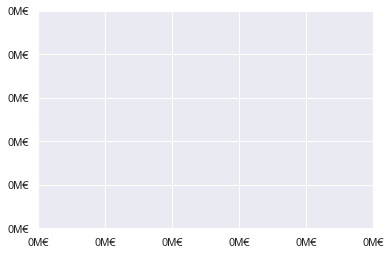

In [192]:
import seaborn as sns
from matplotlib.ticker import FuncFormatter
sns.set_theme()

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM€' % (x * 1e-6)

formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)


investors_chosen = ["Founders", "Investor 1", "Investor 6"]
floor = 10000000
ceiling = 200000000
step = 10000000

graphe = []

for sale_price in range (floor, ceiling+step, step):
    liquid_pref, liquid_pref_styled = liquid_pref_function(cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, sale_price)
    proceeds = []
    for investor in investors_chosen:
        proceeds.append(liquid_pref["Total proceeds"][investor])
    graphe.append(proceeds)

x= range(floor, ceiling+step, step)

for i in range (len(investors_chosen)):
    plt.plot(x, [item[i] for item in graphe], label=investors_chosen[i])

plt.legend(loc="upper left")
plt.title("Simulation liquid pref")
plt.xlabel("Sale_price")
plt.ylabel("Proceeds")
plt.show()

In [ ]:
import plotly.graph_objects as go

floor = 10000000
ceiling = 200000000
step = 10000000
graphe = []
x = []
for i in range(floor, ceiling+step, step):
    x.append(i)



for sale_price in range (floor, ceiling+step, step):
    liquid_pref, liquid_pref_styled = liquid_pref_function(cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, sale_price)
    proceeds = []
    for investor in investors:
        proceeds.append(liquid_pref["Total proceeds"][investor])
    graphe.append(proceeds)


fig = go.Figure()
for i in range (len(investors)):
    fig.add_trace(go.Scatter(x=x, y=[item[i] for item in graphe],
                    mode='lines',
                    name=investors[i]))

fig.update_layout(title='<b>Liquid pref simulation</b>', title_x=0.5,
                   xaxis_title='Sale price (€)',
                   yaxis_title='Proceeds (€)')
fig.show()

df = pd.DataFrame(np.array(graphe).T.tolist(), columns=range (floor, ceiling+step, step), index=investors)
df


In [ ]:
from plotly.offline import plot
import plotly.graph_objects as go

floor = 10000000
ceiling = 200000000
step = 10000000
graphe = []
x = []
for i in range(floor, ceiling+step, step):
    x.append(i)


for sale_price in range (floor, ceiling+step, step):
    liquid_pref, liquid_pref_styled = liquid_pref_function(cap_table, series, investors, options_holders, options_class, first_step, carve_out_rate, multiples_pref, participating, shares_prices, sale_price)
    proceeds = []
    for investor in investors:
        proceeds.append(liquid_pref["Total proceeds"][investor])
    graphe.append(proceeds)

graphs = []

for i in range (len(investors)):
    graphs.append(go.Scatter(x=x, y=[item[i] for item in graphe],
                    mode='lines',
                    name=investors[i]))

layout = {
        'title': '<b>Liquid pref simulation</b>',
        'xaxis_title': 'Sale price (€)',
        'yaxis_title': 'Proceeds (€)',
        'title_x': 0.5
    }

plot_div = plot({'data': graphs, 'layout': layout}, 
                    output_type='div')

plot_div